In [1]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image


In [2]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    #preprocessing_function=to_grayscale_then_rgb,
    validation_split=0.26)

train_generator = train_datagen.flow_from_directory(
    r"ASD\Contrasted",
    target_size=(400, 400),
    batch_size=8,
    class_mode='binary',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    r"ASD\Contrasted", # same directory as training data
    target_size=(400, 400),
    batch_size=1,
    class_mode='binary',
    subset='validation')

Found 406 images belonging to 2 classes.
Found 141 images belonging to 2 classes.


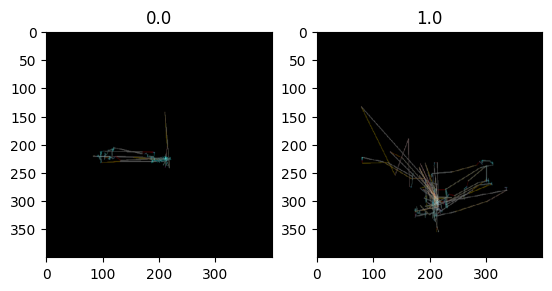

In [3]:
images, labels = train_generator.next()

fig, axes = plt.subplots(1, 2)
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i])
    ax.set_title(labels[i])
# show the figure
plt.show()

In [5]:
##Defining the Network 
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=7, activation ='relu', input_shape=[400,400,3]))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#cnn.add(tf.keras.layers.Dropout(0.20))

cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=5, activation ='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
#cnn.add(tf.keras.layers.Dropout(0.20))

cnn.add(tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation ='relu'))
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(0.20))

cnn.add(tf.keras.layers.Flatten())

cnn.add(tf.keras.layers.Dense(units= 128, activation = 'relu'))

cnn.add(tf.keras.layers.Dense(units= 64, activation = 'relu'))
cnn.add(tf.keras.layers.Dense(units= 1, activation = 'sigmoid'))
opt = tf.keras.optimizers.Adam(learning_rate=0.00005)

cnn.compile(optimizer = opt, loss = 'binary_focal_crossentropy', metrics = ['accuracy'])
cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 394, 394, 64)      9472      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 197, 197, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 193, 193, 64)      102464    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 96, 96, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 94, 94, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 47, 47, 64)      

In [6]:
history = cnn.fit(train_generator, validation_data=validation_generator, epochs = 8)

Epoch 1/8
51/51 [==============================] - 106s 2s/step - loss: 0.1605 - accuracy: 0.6305 - val_loss: 0.1302 - val_accuracy: 0.7730
Epoch 2/8
51/51 [==============================] - 103s 2s/step - loss: 0.1256 - accuracy: 0.7759 - val_loss: 0.1206 - val_accuracy: 0.7447
Epoch 3/8
51/51 [==============================] - 104s 2s/step - loss: 0.0992 - accuracy: 0.8374 - val_loss: 0.1320 - val_accuracy: 0.7447
Epoch 4/8
51/51 [==============================] - 106s 2s/step - loss: 0.0754 - accuracy: 0.8916 - val_loss: 0.1477 - val_accuracy: 0.7447
Epoch 5/8
51/51 [==============================] - 105s 2s/step - loss: 0.0600 - accuracy: 0.9187 - val_loss: 0.2441 - val_accuracy: 0.6879
Epoch 6/8
51/51 [==============================] - 106s 2s/step - loss: 0.0325 - accuracy: 0.9581 - val_loss: 0.2370 - val_accuracy: 0.7234
Epoch 7/8
51/51 [==============================] - 104s 2s/step - loss: 0.0129 - accuracy: 0.9877 - val_loss: 0.2728 - val_accuracy: 0.7518
Epoch 8/8
51/51 [===

In [7]:
##Confusion Matrix Generator and ROC Curve
y_pred_real = cnn.predict(validation_generator)
y_pred = [int(p >= 0.5) for p in y_pred_real] ##With sigmoid 1 neuron
##y_pred = np.argmax(Y_pred, axis=1) ##With softmax and 2 neurons 
y_true = validation_generator.classes
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(validation_generator.classes, y_pred)
print(cm)

141/141 [==============================] - 7s 52ms/step
[[41 44]
 [32 24]]


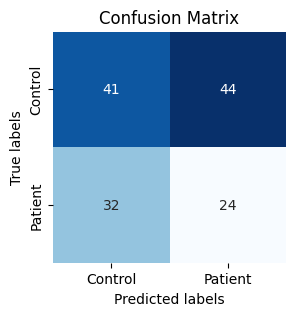

In [8]:
# Define the class labels
class_names = validation_generator.class_indices.keys()
import seaborn as sns
# Plot the confusion matrix as an image
fig, ax = plt.subplots(figsize=(3, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, xticklabels=class_names, yticklabels=class_names, ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

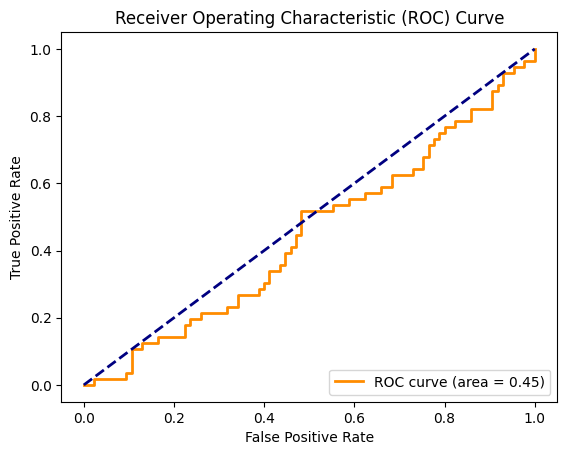

In [9]:
# Calculate the ROC curve and AUC score, sklearn takes probabilities instead of classes
fpr, tpr, thresholds = roc_curve(y_true, y_pred_real)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()